In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utils import load_model_and_tokenizer, obtain_all_ice_variants, train_test_split_per_template, evaluate
from src.function_vectors import generate_head_activations_last_token, compute_head_impact, extract_and_average_head_activations, apply_function_vector
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
MODEL_NAME = 'EleutherAI/pythia-12b-deduped-v0'

### Load the model and the dataset

In [3]:
tokenizer, model = load_model_and_tokenizer(MODEL_NAME, device)
dataset = torch.load('./data/pythia_12b_data.pt')

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model EleutherAI/pythia-12b-deduped-v0 into HookedTransformer


## 1. Experiments with numbers in numerical representations

In [4]:
dataset_numerical = dataset[:len(dataset)//2]
datset_word = dataset[len(dataset)//2:]

### Preprocess the dataset and divide it into validation and test sets

In [5]:
val, test = train_test_split_per_template(dataset_numerical, test_size=0.33, num_samples_per_template=30)

val_no_ice, val_single_ice, val_two_ice, val_all_ice = obtain_all_ice_variants(val)
test_no_ice, test_single_ice, test_two_ice, test_all_ice = obtain_all_ice_variants(test)
val_sets = [val_no_ice, val_single_ice, val_two_ice, val_all_ice]
test_sets = [test_no_ice, test_single_ice, test_two_ice, test_all_ice]

### Evaluate the model on the validation and test sets

In [26]:
results_val_no_ice, results_val_single_ice, results_val_two_ice, results_val_all_ice = [evaluate(tokenizer, model, val_set, batch_size=1, prepend_bos=True) for val_set in val_sets]
results_test_no_ice, results_test_single_ice, results_test_two_ice, results_test_all_ice = [evaluate(tokenizer, model, test_set, batch_size=1, prepend_bos=True) for test_set in test_sets]
results_val = [results_val_no_ice, results_val_single_ice, results_val_two_ice, results_val_all_ice]
results_test = [results_test_no_ice, results_test_single_ice, results_test_two_ice, results_test_all_ice]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

In [27]:
print("Validation Results (No ICE, Single ICE, Two ICE, All ICE):", [np.round(np.mean(res), 3) for res in results_val])
print("Test Results (No ICE, Single ICE, Two ICE, All ICE):", [np.round(np.mean(res), 3) for res in results_test])

Validation Results (No ICE, Single ICE, Two ICE, All ICE): [0.536, 0.664, 0.65, 0.65]
Test Results (No ICE, Single ICE, Two ICE, All ICE): [0.486, 0.643, 0.7, 0.7]


### Extract vectors that attention heads write to the residual stream of the final token
Perform extraction only from correctly solved instances

As the highest accuracy on validation is achieved with only one in-context example, we extract function vectors from instances with only one in-context example.

In [47]:
solved_prompts_val_single_ice = [item[0] for idx, item in enumerate(val_single_ice) if results_val_single_ice[idx] == 1]
activations = generate_head_activations_last_token(model, solved_prompts_val_single_ice, batch_size=1)
activations = torch.stack(activations, dim=0)

  0%|          | 0/93 [00:00<?, ?it/s]

### Compute the impact of each head's on the logit of the correct answer on the validation set

In [ ]:
# attenton: running this cell might take a while
# head_importances = compute_head_impact(model, tokenizer, val_no_ice, activations, batch_size=10)

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
# torch.save(head_importances, './data/pythia_12b_function_vector_head_impacts_numerical.pt')
head_importances = torch.load('./data/pythia_12b_function_vector_head_impacts_numerical.pt')

### Plot head impacts

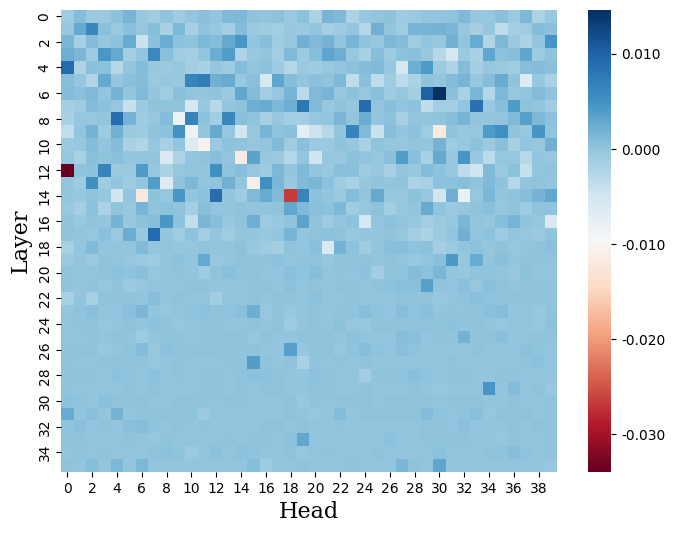

In [51]:
plt.figure(figsize=(8, 6))
sns.heatmap(head_importances, annot=False, cmap='RdBu', fmt='.2f', cbar_kws={'format': '%.3f'})
plt.xlabel('Head', fontsize=16, fontname='DeJavu Serif')
plt.ylabel('Layer', fontsize=16, fontname='DeJavu Serif')
plt.show()

### Select top-k heads based on their impact

In [60]:
top = 30
num_random_head_samples = 5

num_layers, num_heads = head_importances.shape
top_head_indices = torch.topk(head_importances.flatten(), top).indices
num_random_head_samples = [torch.randperm(len(head_importances.flatten()))[:top] for _ in range(num_random_head_samples)]

top_heads = [((idx // num_heads).item(), (idx % num_heads).item()) for idx in top_head_indices]
random_heads = [[((idx // num_heads).item(), (idx % num_heads).item()) for idx in rand_indices] for rand_indices in num_random_head_samples]

### Create Function Vector

In [61]:
function_vector = extract_and_average_head_activations(model, top_heads, activations) 
function_vectors_random = [extract_and_average_head_activations(model, rand_heads, activations) for rand_heads in random_heads]

### Apply Function Vector and evaluate its effect on performance

In [62]:
results_function_vector = apply_function_vector(model, tokenizer, test_no_ice, function_vector.to(model.cfg.device), batch_size=1)
results_function_vector_random = [apply_function_vector(model, tokenizer, test_no_ice, function_vector_random.to(model.cfg.device), batch_size=1) for function_vector_random in function_vectors_random]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

### Plot results

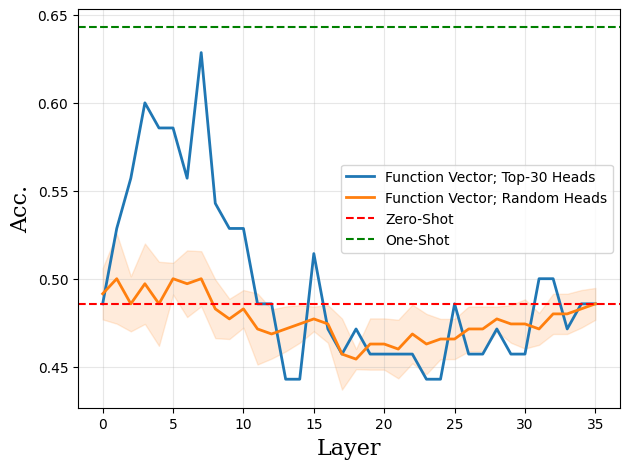

In [ ]:
layers = np.arange(len(results_function_vector))

# Top heads function vector line
plt.plot(layers, results_function_vector, linewidth=2,
         label=f'Function Vector; Top-{top} Heads')

# Mean and std across random runs
random_arr = np.array(results_function_vector_random, dtype=float)
mean_random = random_arr.mean(axis=0)
std_random = random_arr.std(axis=0)
plt.plot(layers, mean_random, color='C1', linewidth=2, label='Function Vector; Random Heads')
plt.fill_between(layers, mean_random - std_random, mean_random + std_random,
                 color='C1', alpha=0.15)

# Baselines
plt.axhline(y=np.mean(results_test_no_ice), color='r', linestyle='--', label='Zero-Shot')
plt.axhline(y=np.mean(results_test_single_ice), color='g', linestyle='--', label='One-Shot')

plt.xlabel('Layer', fontsize=16, fontname='DeJavu Serif')
plt.ylabel('Acc.', fontsize=16, fontname='DeJavu Serif')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

## 1. Experiments with numbers in word representations